In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-09-05 20:41:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-09-05 20:41:25 (149 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


W0905 20:41:27.080864 140612876724096 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/initializers.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 20:41:27.114465 140612876724096 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 20:41:27.125221 140612876724096 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be r

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [4]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

W0905 20:41:28.318041 140612876724096 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 43s 3ms/sample - loss: 6.9015 - acc: 0.0200
Epoch 2/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.5004 - acc: 0.0211
Epoch 3/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.3992 - acc: 0.0242
Epoch 4/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.2682 - acc: 0.0320
Epoch 5/100
15462/15462 [==============================] - 42s 3ms/sample - loss: 6.1632 - acc: 0.0382
Epoch 6/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.0765 - acc: 0.0393
Epoch 7/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 5.9947 - acc: 0.0404
Epoch 8/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 5.9032 - acc: 0.0463
Epoch 9/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 5.8039 - acc: 0.0520
Epoch 10/100
15462/15462 [==============================] - 41s 3ms/sampl

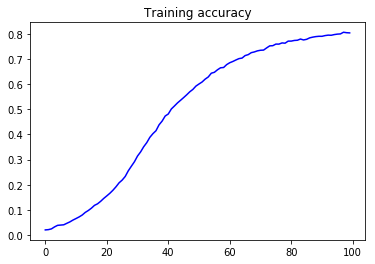

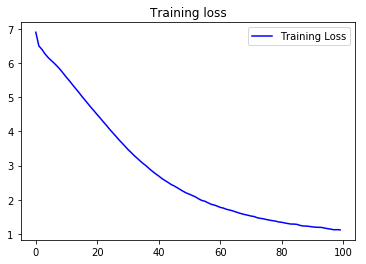

In [5]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [6]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope their eye with gracious must see take too lie in me day die her prove thee hate ' ' lies torn forsaken forsaken forsaken grossly affords cold breeds hid kind do thine bright slain take my use thee mine eye acquainted so clear ' doth prove bright thee live dear bright thee shows it am so strongly in thee hid confounds forth them mine bright thee die he write doth thee bright thee bright well bright thee grace an worthless overthrow enclose rain leaves grow up hate cold leaves cured precious cold cured date cold ' shows thee still bright
